In [1]:
import cv2
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.models import model_from_json
import matplotlib.pyplot as plt


In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth where we are limiting the memory consumption of tensorflow
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Preprocessing

In [3]:
# Define a custom preprocessing function for sharpening
def sharpen_image(image):
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (0, 0), 3)# The kernal(0,0) , sigma=3 .

    # Perform high-pass filtering for edge enhancement
    #adding the weighted combination of the (gray) and (blurred). 
    # The weight of the grayscale image= 2 ,the weight of the blurred= -1 .
    sharp = cv2.addWeighted(image, 2, blurred, -1, 0)
    # Return the sharpened image
    return sharp

In [4]:
# Initialize image data generator with sharpening
train_data_gen = ImageDataGenerator(preprocessing_function=sharpen_image)

validation_data_gen = ImageDataGenerator(preprocessing_function=sharpen_image)


In [5]:
# Initialize image data generator with rescaling
#our max=255 and our min=0 so we want the minimum value so it can be easier to compute 
#make them between zero and one
train_data_gen = ImageDataGenerator(rescale=1./255)
validation_data_gen = ImageDataGenerator(rescale=1./255)

In [6]:
# Preprocess all train images
#getting another batch every time we iterate
#our images are converted to arrays and classified into labels 
train_generator = train_data_gen.flow_from_directory(
    'train',
    target_size=(48, 48),
    batch_size=64,
    color_mode="grayscale",
    class_mode='categorical')  # encoded labels for each class

Found 23894 images belonging to 5 classes.


In [7]:
len(train_generator)

374

In [8]:
# Preprocess all test images
validation_generator = validation_data_gen.flow_from_directory(
    'test',
    target_size=(48, 48),
    batch_size=64,
    color_mode="grayscale",
    class_mode='categorical')

Found 5989 images belonging to 5 classes.


In [9]:
len(validation_generator)

94

# Build Deep Learning Model

In [10]:
# create model structure
#our first layer is a 2d convolution with 16 filters where it extracts info to classifiy the image
#3,3-->size of filter and 'relu' is converting any negative val to 0 and positive unchanged, it works for non-linear pattern

emotion_model = Sequential()

emotion_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)))
emotion_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))#return max value of relu
emotion_model.add(Dropout(0.25))

emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))

emotion_model.add(Flatten())

emotion_model.add(Dense(1024, activation='relu'))
emotion_model.add(Dropout(0.5))
emotion_model.add(Dense(5, activation='softmax'))



In [11]:
#tf.keras.optimizers.Optimizer??
emotion_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001, decay=1e-6), metrics=['accuracy'])

In [12]:
print(emotion_model.input_shape)


(None, 48, 48, 1)


In [13]:
emotion_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 22, 22, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 22, 22, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 128)      0         
 2D)                                                    

In [14]:
#log my training performance
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
# Train the neural network/model
emotion_model_info=emotion_model.fit(train_generator, epochs=20, validation_data=validation_generator, callbacks=[tensorboard_callback])


Epoch 1/20
374/374 [==============================] - 208s 551ms/step - loss: 1.5430 - accuracy: 0.3151 - val_loss: 1.4179 - val_accuracy: 0.4308
Epoch 2/20
374/374 [==============================] - 203s 543ms/step - loss: 1.3305 - accuracy: 0.4510 - val_loss: 1.2321 - val_accuracy: 0.4994
Epoch 3/20
374/374 [==============================] - 192s 514ms/step - loss: 1.2235 - accuracy: 0.5062 - val_loss: 1.1478 - val_accuracy: 0.5425
Epoch 4/20
374/374 [==============================] - 181s 483ms/step - loss: 1.1498 - accuracy: 0.5406 - val_loss: 1.0855 - val_accuracy: 0.5692
Epoch 5/20
374/374 [==============================] - 168s 449ms/step - loss: 1.0873 - accuracy: 0.5676 - val_loss: 1.0443 - val_accuracy: 0.5826
Epoch 6/20
374/374 [==============================] - 169s 453ms/step - loss: 1.0344 - accuracy: 0.5901 - val_loss: 1.0017 - val_accuracy: 0.6046
Epoch 7/20
374/374 [==============================] - 180s 480ms/step - loss: 0.9923 - accuracy: 0.6121 - val_loss: 0.9804 -

 # Performance

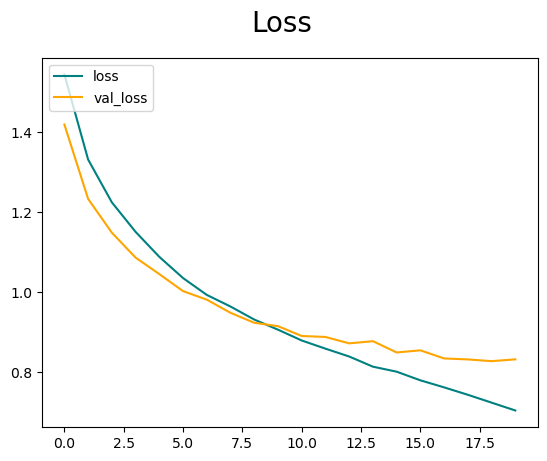

In [15]:
#Loss data 
fig = plt.figure()
plt.plot(emotion_model_info.history['loss'], color='teal', label='loss')
plt.plot(emotion_model_info.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

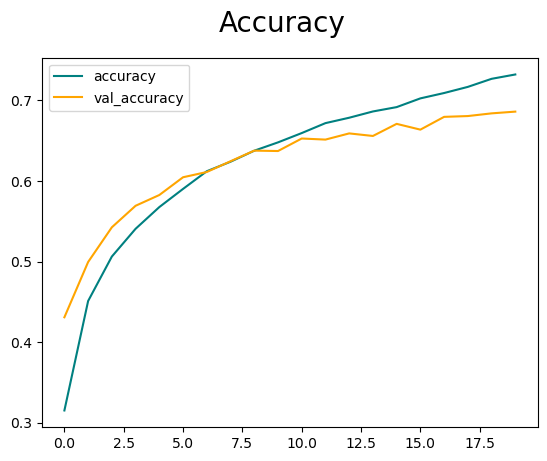

In [16]:
#accuracy
fig = plt.figure()
plt.plot(emotion_model_info.history['accuracy'], color='teal', label='accuracy')
plt.plot(emotion_model_info.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Save Model

In [17]:
# save model structure in jason file
model_json = emotion_model.to_json()
with open("emotion_model.json", "w") as json_file:
    json_file.write(model_json)

# save trained model weight in .h5 file
emotion_model.save_weights('emotion_model.h5')